In [1]:
import numpy as np
import torch
from tqdm.notebook  import tqdm
import pickle
import copy
from pprint import pprint

from jeffutils.utils import reimport
from models.pytorch_model import OrigamiNetwork
reimport("from models.pytorch_model import OrigamiNetwork", globals())
from vis_helpers import *
reimport("from vis_helpers import *", globals())

### Data

In [2]:
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    return D + mask[:,np.newaxis] * (2*n - (2 * np.outer(scales, n)))
fv1 = np.array([0,.5])
size = 10
X1, X2 = np.meshgrid(np.linspace(-2,2,size), np.linspace(-2,2,size))
sandwichX = np.concatenate((X1.reshape(-1,1), X2.reshape(-1,1)), axis=1)
sandwichY = layer_sam(sandwichX, fv1)[:,1] > -.5
# plt.scatter(sandwichX[:,0], sandwichX[:,1], c=sandwichY)
sandwichX = torch.tensor(sandwichX, dtype=torch.float32)
sandwichY = torch.tensor(sandwichY, dtype=torch.float32)

size = 30
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)
xorX = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
xorY = np.array([[1 if (i < size//2 and j < size//2 or i >= size//2 and j >= size//2) else 0 for j in range(size)] for i in range(size)]).reshape(-1)
# plt.scatter(xorX[:,0], xorX[:,1], c=xorY)
xorX = torch.tensor(xorX, dtype=torch.float32)
xorY = torch.tensor(xorY, dtype=torch.float32)

count = 20
onedX = np.linspace(-2,2,count)
onedY = np.zeros(count)
onedY[:6] = 1
onedY[-6:] = 1
onedX = np.expand_dims(onedX, axis=1)
onedX = torch.tensor(onedX, dtype=torch.float32)
onedY = torch.tensor(onedY, dtype=torch.float32)

## Training

In [3]:
test_case_x = xorX
test_case_y = xorY
print("Testing xor problem")
layers = 2
test = OrigamiNetwork(n_layers=layers, width=None, epochs=300, 
                      learning_rate=0.01, optimizer_type="adam", crease=None)
test.load_data(test_case_x, test_case_y)
# test.set_folds([np.array([-0.00466453, 0.53786325])])
test.fit()
logits, out = test.forward(test_case_x, return_intermediate=True)

# print("\nScore =", test.score(), "after training")
print("Cut", test.get_cut_vector(), "Fold vectors", sep="\n")
pprint(test.get_fold_vectors())

Testing xor problem


Training: 100%|██████████| 300/300 [00:33<00:00,  8.93it/s]

Cut
[[ 0.9943781 -8.413236 ]
 [-1.0714421  9.539991 ]]
Fold vectors
{'Layer 0': {'crease': array([8.596922], dtype=float32),
             'hyperplane': array([-0.07977362,  0.0991271 ], dtype=float32)},
 'Layer 1': {'crease': array([4.4746566], dtype=float32),
             'hyperplane': array([-0.14189415, -0.1899569 ], dtype=float32)}}


In [4]:
reimport("from vis_helpers import *", globals())
for l in range(layers):
    plot_wiggles(test.get_history("fold"), test.get_history("crease"), layer=l)

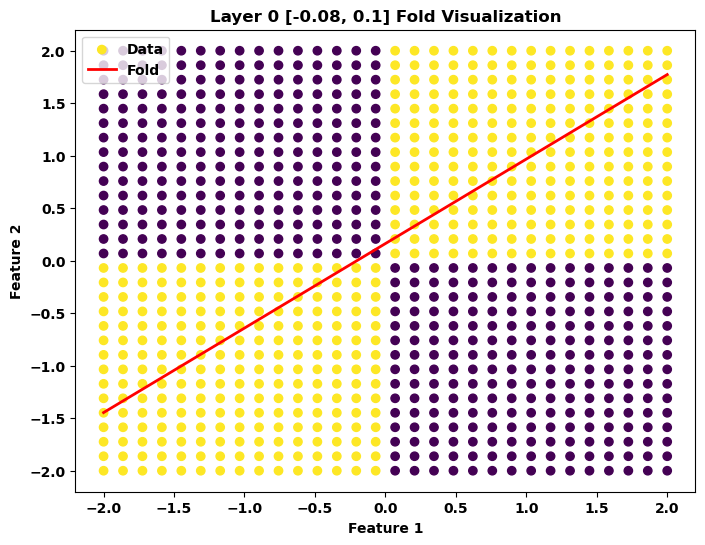

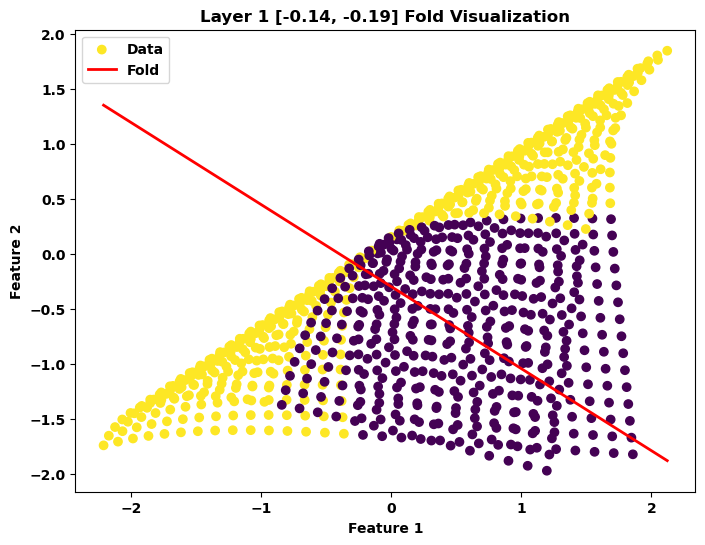

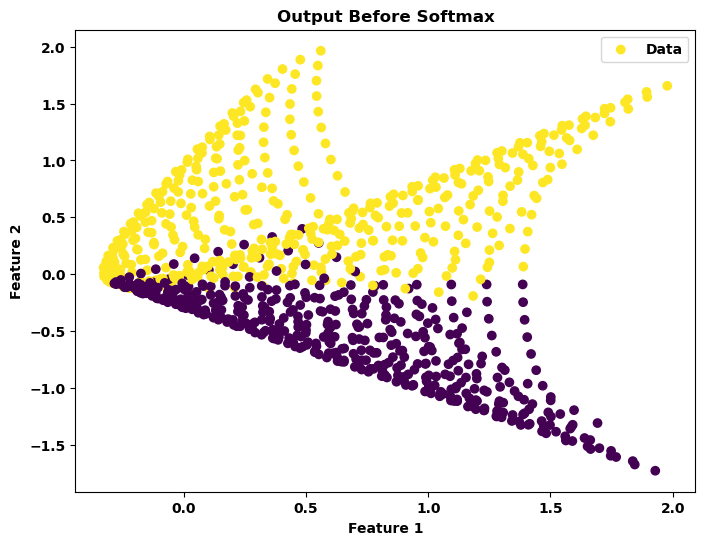

In [5]:
# Visualize folds at each layer
# reimport("from models.pytorch_model_old import OrigamiNetwork", globals())
# reimport("from vis_helpers import *", globals())
for layer_index in range(layers+1):
    plot_folds(test, layer_index=layer_index, use_plotly=False)

Plotting: 100%|██████████| 50/50 [00:00<00:00, 684.93it/s]


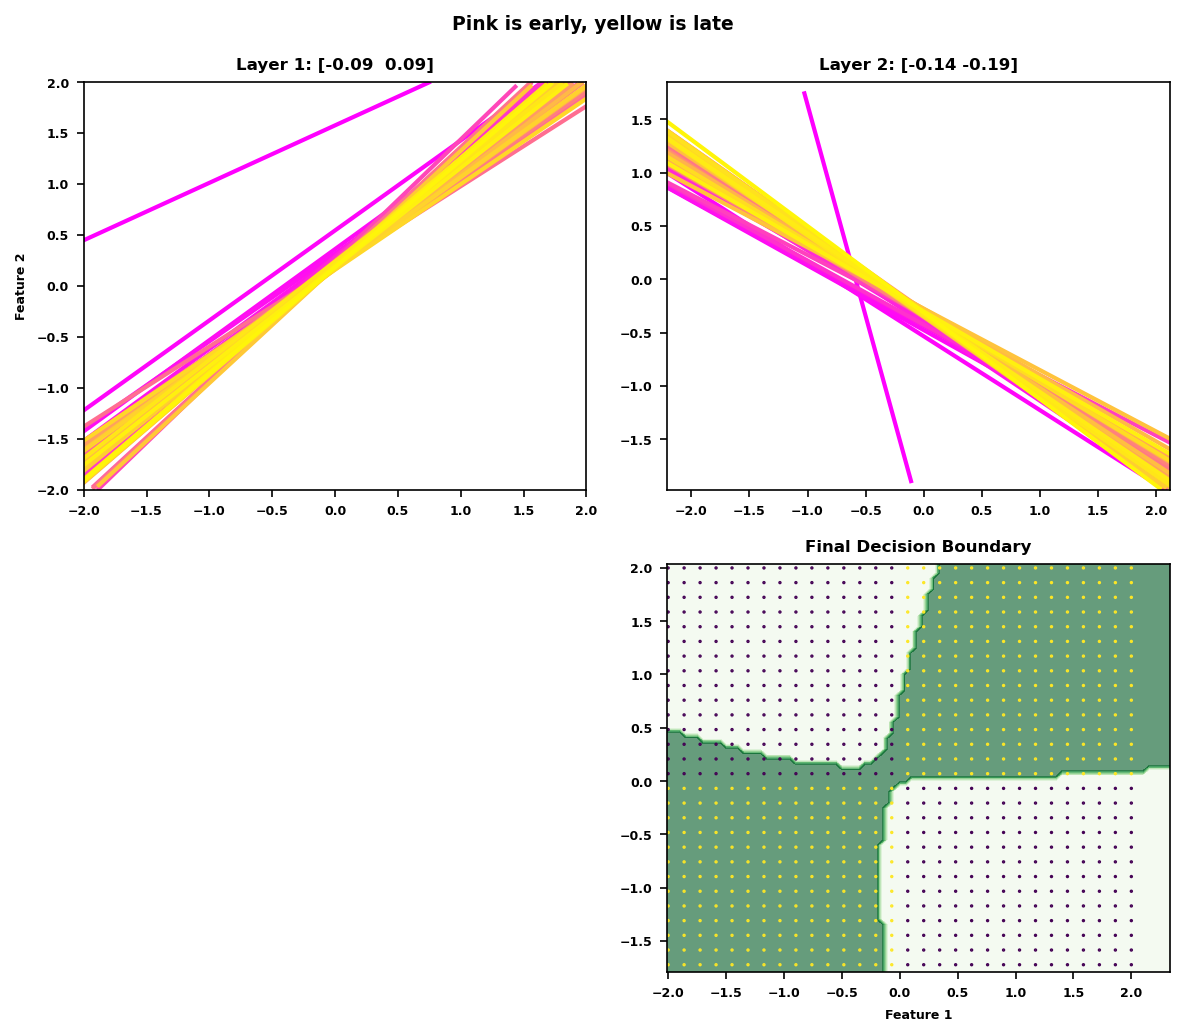

In [6]:
reimport("from vis_helpers import *", globals())
plot_history(test, verbose=2)

In [18]:
pprint(test.get_fold_vectors())

{'Layer 0': {'crease': array([8.596922], dtype=float32),
             'hyperplane': array([-0.07977362,  0.0991271 ], dtype=float32)},
 'Layer 1': {'crease': array([4.4746566], dtype=float32),
             'hyperplane': array([2., 2.], dtype=float32)}}


In [16]:
reimport("from vis_helpers import *", globals())
max_score, best_folds = iscore_landscape(test, score_layers=None, create_plot=True, density=31, verbose=1)

score Layer 0: 100%|██████████| 961/961 [00:01<00:00, 798.84it/s]


score Layer 1: 100%|██████████| 961/961 [00:01<00:00, 688.89it/s]
